In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import os
import warnings

from keras import backend as K

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense

from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from sys import platform

#all the functions are in this module
from EEGAnalysis import *

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
def newSession(GPU=0, CPU=8, randomSeed = 8):
    #delete previous model and set up session
    np.random.seed(randomSeed)
    tf.keras.backend.clear_session()
    config = tf.ConfigProto(device_count={'GPU':GPU, 'CPU':CPU})
    config.gpu_options.allow_growth = True
    tf.keras.backend.set_session(tf.Session(config=config))
    gc.collect()

In [3]:
#run this cell for the recording with only a beep sound

#import the file
filename = 'EEGdata/beeps_2019.03.25_15.04.47.edf'
rate = 256

#readEDF-function in python module EEGAnalysis
EEGData, markerData, motionData = readEDF(filename, CQ = True, markers = True, motion = True, powerLineHumFilter = True)
xTrain, yTrain, xTest, yTest = None, None, None, None

classes = ['blank', 'beep']

events = createEvents(markerData, eventIDs = np.array([7]))
events = createEventsSetIntervals(events[0][0], 4, numIntervals = 200, classes = classes, rate = rate, experiment = 'custom')

#create Epochs
tmin = 0  # set time around events to create Epochs
tmax = 2

#PSD or signal
normalize = True
fourier = False

returning EEGData, markerData, motionData
last event at time:  209662.0


In [10]:
#run this cell for the recording with music (Wicked soundtrack)

#import the file

filename = 'EEGdata/WickedInstrum10sSilence10sMusic_2019.05.13_15.13.18.edf'
rate = 256

#readEDF-function in python module EEGAnalysis
EEGData, markerData, motionData = readEDF(filename, CQ = True, markers = True, motion = True, powerLineHumFilter = True)
xTrain, yTrain, xTest, yTest = None, None, None, None

classes = ['blank', 'music']

events = createEvents(markerData, eventIDs = np.array([3]))
events = createEventsSetIntervals(events[0][0], 20, numIntervals = 115, classes = classes, rate = rate, experiment = 'custom')

#create Epochs
tmin = 0  # set time around events to create Epochs
tmax = 10

#PSD or signal
normalize = True
fourier = False

returning EEGData, markerData, motionData
last event at time:  603631.0


In [11]:
(xTrain, yTrain),(xTest, yTest) = createEpochs(EEGData, events, tmin, tmax, normalize = normalize, verbose = False, fourier = fourier)

Done making training/test-sets, shapes:  (207, 2561, 14) (207, 2) (23, 2561, 14) (23, 2)


In [12]:
#hyperparameters
verbose = 0
batchSizeGlobal = 32
epochs = 30 #number of times the network is trained on the entire set.
loadPreviousModels = False #loads the checkpoints
run = '0500-Music-'
LR = 1e-3
loss = 'binary_crossentropy'
metrics = ['accuracy', f1]
patience = 10
min_delta = 1e-5

#prevent naive model
classWeight = {}
for i in range(len(classes)):
    classWeight[i] = unpackClasses(yTrain).tolist().count(i)

newSession()

print(xTrain.shape[0], 'train samples')
print(xTest.shape[0], 'test samples')

#build model
initializer = None

model = Sequential()
model.add(Flatten(input_shape= (xTrain.shape[1:])))
model.add(Dense(64, activation='relu',
                kernel_initializer = initializer))
model.add(Dropout(rate = 0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.3))
model.add(Dense(len(yTest[0]), activation='sigmoid'))
model.summary()

optimizer = tf.keras.optimizers.Adam(lr=LR)#, decay=1.5)#rho=rho, epsilon=epsilon,
model.compile(optimizer=optimizer, loss=loss,  metrics=metrics)

#make filepaths
networkname = run + makeNameModel(model)
time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
logDir = './sound/logs/' + networkname + time
modelFile = './sound/logs/' + networkname + '.hdf5'
if platform.count('Windows'):
    logDir = os.getcwd() + logDir
    modelFile = os.getcwd() + modelFile
    if not loadPreviousModels:
        os.makedirs(logDir)

if loadPreviousModels:
    model.load_weights(modelFile)

# prepare callbacks and checkpoint learning
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logDir, histogram_freq=0,
                            write_graph=True, write_images=False, write_grads = True, update_freq = 'epoch')
checkpoint = tf.keras.callbacks.ModelCheckpoint(modelFile, monitor='val_loss', mode = 'min', period=5, save_best_only=False)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience=patience, min_delta = min_delta)
histories = Histories()

print(networkname)

#batch size
batch_size = 32

model.fit(xTrain, yTrain, epochs=epochs, batch_size=batch_size, verbose = verbose,
          callbacks = [tensorboard, checkpoint, earlyStopping, histories],
          validation_data=(xTest, yTest), class_weight=classWeight)

trainResult = np.array([histories.loss, histories.acc, histories.f1])
testResult = np.array([histories.val_loss, histories.val_acc, histories.val_f1])

score = model.evaluate(xTest, yTest, verbose=1)

y_pred = model.predict_classes(xTest)
y_true = unpackClasses(yTest)
conf_matrix_test = confusion_matrix(y_true, y_pred)
dispMat(conf_matrix_test, names = classes)

temp = 0
for i in model.metrics_names:
    print('Test', str(i), ':', round(score[temp], 2))
    temp += 1

207 train samples
23 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 35854)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2294720   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 2,303,298
Trainable params: 2,303,298
Non-trainable params: 0
________________________________

,blank,music
blank,6,4
music,4,9


Test loss : 1.41
Test acc : 0.65
Test f1 : 0.65


In [13]:
#log the results in a .npy file
logDir = os.getcwd() + '/beeps/logsNpy'
trainFile = logDir + '/' + networkname + '-train'
testFile = logDir + '/' +  networkname + '-test'

try:
    np.save(trainFile, trainResult)
    np.save(testFile, testResult)
except:
    os.makedirs(logDir)
    np.save(trainFile, trainResult)
    np.save(testFile, testResult)

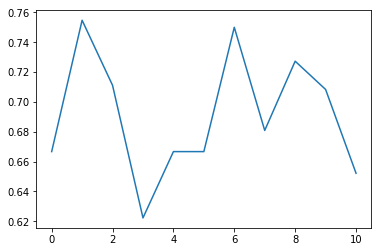

In [16]:
plt.plot(testResult[2])